import necessary packet

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import serial
import csv
import matplotlib as mpl
from scipy.signal import butter, filtfilt, freqz
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from concurrent.futures import ThreadPoolExecutor
import struct
import matplotlib.animation as animation


In [ ]:
%matplotlib inline
#select environment for plotting

An example of EEG data processing. We first feed our signal in to gaussian noise, then attemptto filter out the signal we fed in. 

In [ ]:


# Parameters
fs = 1000  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # Time vector
f1 = 50  # Frequency of the first sine wave (Hz),
f2 = 150  # Frequency of the second sine wave (Hz)
noise_level = 1  # Noise level

# Create the signal, this is an example of an EEG signal that we wish to extract
signal = np.sin(2 * np.pi * f1 * t) + np.sin(2 * np.pi * f2 * t)
signal1= np.sin(2 * np.pi * f1 * t)  #50 
signal2 =np.sin(2 * np.pi * f2 * t)  #150
noise = noise_level * np.random.randn(len(t))  # Gaussian noise
noisy_signal = signal + noise

# Plot the noisy signal
plt.figure(figsize=(12, 6))
plt.plot(t, noisy_signal)
plt.title("Noisy Signal (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


In [ ]:

def fftfunc_graph(signal, fs, y_limit=20):
    """
    Computes the FFT of a signal and plots the frequency domain representation.

    Parameters:
    - signal (array-like): The input signal.
    - fs (float): The sampling frequency of the signal.
    - y_limit (float): The limit for the Y-axis of the plot.

    Returns:
    - fft_result (numpy array): The FFT of the signal.
    - fft_freqs (numpy array): The corresponding frequencies of the FFT.
    """
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal), 1/fs)

    # Plot the FFT result
    plt.figure(figsize=(12, 6))
    plt.plot(fft_freqs[:len(fft_freqs)//2], np.abs(fft_result)[:len(fft_freqs)//2])
    plt.ylim(0, y_limit)
    plt.title("Noisy Signal (Frequency Domain)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()
    
    return fft_result, fft_freqs


    
def bandpass_filter(signal, fs, lowcut, highcut):
    nyquist = 1/2 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_signal = filtfilt( b, a, signal)
    return filtered_signal



In [ ]:


# Apply the filters
filtered_signal_50hz = bandpass_filter(noisy_signal, fs, 49, 51)
filtered_signal_150hz = bandpass_filter(noisy_signal,  fs, 149, 151)

# Plot the filtered signals
plt.figure(figsize=(12, 12))
plt.subplot(5, 1, 1)
plt.plot(t, signal1)
plt.title("orginal signal(50hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")


plt.subplot(5, 1, 2)
plt.plot(t, signal2)
plt.title("orginal signal(150hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")


plt.subplot(5, 1, 3)
plt.plot(t, noisy_signal)
plt.title("Noisy Signal (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(5, 1, 4)
plt.plot(t, filtered_signal_50hz)
plt.title("Filtered Signal (45-55 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(5, 1, 5)
plt.plot(t, filtered_signal_150hz)
plt.title("Filtered Signal (145-155 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()
fftfunc_graph(noisy_signal, fs, y_limit=1000)


This codes below are fuctional code

In [18]:
def control_teensy(port, baud_rate, sample_rate, running_time, analog_pins):
    """
    Control Teensy via serial commands and read voltage input from specified analog pins.

    Parameters:
    - port (str): The serial port (e.g., 'COM3' or '/dev/tty.usbmodem1234').
    - baud_rate (int): The baud rate for serial communication.
    - sample_rate (int): The sample rate to be set.
    - running_time (int): The running time in seconds.
    - analog_pins (list of int): List of analog pins to read from.
    
    Returns:
    - x_data (list): Time values in seconds.
    - y_data (list of lists): Voltage readings for each pin over time.
    """
    num_pins = len(analog_pins)  # Number of active pins
    buffer_size = 18 * 4  # Total of 18 pins (we still receive the full buffer, with unused pins set to 0)
    x_data = []  # Time values
    y_data = [[] for _ in range(num_pins)]  # Voltage readings for each pin

    try:
        # Open the serial connection to the Teensy
        with serial.Serial(port, baud_rate, timeout=1) as ser:
            time.sleep(2)  # Give time for the connection to establish
            
            start_time = time.time()

            # Send the pin activation command to the Teensy
            pins_str = ','.join(map(str, analog_pins))  # Convert pin list to comma-separated string
            command = f"SET SR {sample_rate};RT {running_time};AP {pins_str}\n"
            ser.write(command.encode())
            print(f"Command sent: {command.strip()}")

            total_samples = 0

            # Read data for the specified running time
            while time.time() - start_time < running_time:
                if ser.in_waiting >= buffer_size:
                    data = ser.read(buffer_size)
                    
                    # Decode data: We will only use data for active pins
                    all_readings = struct.unpack('<' + 'f' * 18, data)  # Read all 18 pins
                    
                    # Get the current timestamp
                    timestamp = time.time() - start_time
                    x_data.append(timestamp)

                    # Append the voltage data only for the active pins
                    for i, pin in enumerate(analog_pins):
                        y_data[i].append(all_readings[pin])

                    total_samples += 1  # Increment the sample count
                    print(f"Received at {timestamp:.3f}s: {[all_readings[pin] for pin in analog_pins]}")

            end_time = time.time()
            total_time = end_time - start_time

            # Calculate the actual sampling rate
            actual_sampling_rate = total_samples / total_time
            print(f"Total data points collected: {total_samples}")
            print(f"Total time: {total_time:.2f} seconds")
            print(f"Actual sampling rate: {actual_sampling_rate:.2f} samples per second")

            # Create plots for each pin
            for i, pin in enumerate(analog_pins):
                plt.figure(figsize=(10, 5))
                plt.plot(x_data, y_data[i], label=f"Pin A{pin}")
                plt.title(f"Voltage Readings for Pin A{pin}")
                plt.xlabel("Time (s)")
                plt.ylabel("Voltage (V)")
                plt.grid(True)
                plt.legend()
                plt.show()

            return x_data, y_data

    except serial.SerialException as e:
        print(f"Error communicating with Teensy: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return [], []
# Example usage

    
    #analog_pins_to_read = [0, 1, 2, 3]  # Replace with the actual pins (e.g., A0, A1, A2, A3)
    #control_teensy(port='COM6', baud_rate=115200, sample_rate=10000, running_time=10, analog_pins=analog_pins_to_read)

# Example usage
# control_teensy(port='COM6', baud_rate=115200, sample_rate=10000, running_time=10, num_pins=18)


def write_to_csv(x_data, y_data, filename="output_data.csv"):
    """
    Writes x and y data to a CSV file.

    Parameters:
    - x_data (list): List of x values (e.g., time values in seconds).
    - y_data (list): List of y values (e.g., voltage readings).
    - filename (str): The name of the CSV file to write the data to.
    """
    # Ensure x_data and y_data are of the same length
    if len(x_data) != len(y_data):
        raise ValueError("x_data and y_data must have the same length.")
    
    # Write the data to a CSV file
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Time (s)", "Voltage (V)"])
        for x, y in zip(x_data, y_data):
            writer.writerow([x, y])
            
#x, y = control_teensy('/dev/tty.usbmodem155143201', 115200, 200, 5, 14)  # 14 corresponds to A0 on Teensy, to find the port do "ls /dev/tty.*" in terminal
#write_to_csv(x, y, filenames = "name.csv")

def bandpass_filter(signal, order, lowcut, highcut, fs):
    """
    Apply a bandpass Butterworth filter to a signal.
    
    Parameters:
    - signal (array-like): The input signal.
    - order (int): The order of the Butterworth filter.
    - lowcut (float): The low cutoff frequency for the bandpass filter.
    - highcut (float): The high cutoff frequency for the bandpass filter.
    - fs (float): The sampling frequency of the signal.

    Returns:
    - filtered_signal (array-like): The filtered signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def normalize_signal(signal):
    """
    Normalize the signal to the range [0, 1].
    
    Parameters:
    - signal (array-like): The input signal to be normalized.

    Returns:
    - normalized_signal (array-like): The normalized signal.
    """
    scaler = MinMaxScaler()
    signal = np.array(signal).reshape(-1, 1)
    normalized_signal = scaler.fit_transform(signal).flatten()
    return normalized_signal

def filter_noise(signal, order, fs, plot=True):
    """
    Filters noise from the signal using bandpass Butterworth filters for different frequency bands.
    
    Parameters:
    - signal (array-like): The raw signal data to be filtered.
    - order (int): The order of the Butterworth filter.
    - fs (float): The sampling frequency of the signal.
    - plot (bool): Whether to plot the original and filtered signals.

    Returns:
    - (tuple): Filtered signals for delta, theta, alpha, and gamma bands.
    """
    # Apply bandpass filters for different brainwave bands
    deltawave = bandpass_filter(signal, order, lowcut=0.5, highcut=4, fs=fs)
    thetawave = bandpass_filter(signal, order, lowcut=4, highcut=8, fs=fs)
    alphawave = bandpass_filter(signal, order, lowcut=8, highcut=12, fs=fs)
    betawave = bandpass_filter(signal, order, lowcut=12, highcut=30, fs=fs)
    gammawave = bandpass_filter(signal, order, lowcut=30, highcut=80, fs=fs)

    
    # Normalize the signals
    signal = normalize_signal(signal)
    deltawave = normalize_signal(deltawave)
    thetawave = normalize_signal(thetawave)
    alphawave = normalize_signal(alphawave)
    betawave = normalize_signal(betawave)
    gammawave = normalize_signal(gammawave)
    
    # Plot the original and filtered signals
    if plot:
        plt.figure(figsize=(15, 10))
        
        plt.subplot(6, 1, 1)
        plt.plot(signal, linewidth=1, label='Original')
        plt.ylabel('Normalized Voltage', fontsize=12)
        plt.title("Original Signal", fontsize=14)
        plt.grid(True)

        plt.subplot(6, 1, 2)
        plt.plot(deltawave, linewidth=1, label='Delta (0.5-4 Hz)')
        plt.ylabel('Voltage', fontsize=12)
        plt.title("Delta Band (0.5-4 Hz)", fontsize=14)
        plt.grid(True)

        plt.subplot(6, 1, 3)
        plt.plot(thetawave, linewidth=1, label='Theta (4-8 Hz)')
        plt.ylabel('Voltage', fontsize=12)
        plt.title("Theta Band (4-8 Hz)", fontsize=14)
        plt.grid(True)

        plt.subplot(6, 1, 4)
        plt.plot(alphawave, linewidth=1, label='Alpha (8-12 Hz)')
        plt.ylabel('Voltage', fontsize=12)
        plt.title("Alpha Band (8-12 Hz)", fontsize=14)
        plt.grid(True)
        
        plt.subplot(6, 1, 5)
        plt.plot(betawave, linewidth=1, label='beta (12-30 Hz)')
        plt.ylabel('Voltage', fontsize=12)
        plt.title("Beta Band (12-30 Hz)", fontsize=14)
        plt.grid(True)

        plt.subplot(6, 1, 6)
        plt.plot(gammawave, linewidth=1, label='Gamma (30-100 Hz)')
        plt.ylabel('Voltage', fontsize=12)
        plt.xlabel('Time', fontsize=12)
        plt.title("Gamma Band (30-100 Hz)", fontsize=14)
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    return deltawave, thetawave, alphawave,betawave, gammawave

Command sent: SET SR 1000;RT 5;AP 0,1,10
Received at 0.001s: [0.15794871747493744, 0.3980952501296997, 0.48029303550720215]
Received at 0.003s: [0.10395604372024536, 0.3876190483570099, 0.47948718070983887]
Received at 0.003s: [0.05721611902117729, 0.37794873118400574, 0.4786813259124756]
Received at 0.003s: [0.023369964212179184, 0.3715018332004547, 0.4778754711151123]
Received at 0.003s: [0.00483516464009881, 0.36666667461395264, 0.47626373171806335]
Received at 0.003s: [0.0, 0.36586081981658936, 0.47223442792892456]
Received at 0.003s: [0.00967032928019762, 0.36666667461395264, 0.46901097893714905]
Received at 0.003s: [0.03384615480899811, 0.372307687997818, 0.46498167514801025]
Received at 0.003s: [0.07494505494832993, 0.3803662955760956, 0.4625641107559204]
Received at 0.003s: [0.12652014195919037, 0.3916483521461487, 0.4625641107559204]
Received at 0.003s: [0.18454211950302124, 0.4053479731082916, 0.4633699655532837]
Received at 0.003s: [0.2465934008359909, 0.41985347867012024, 0

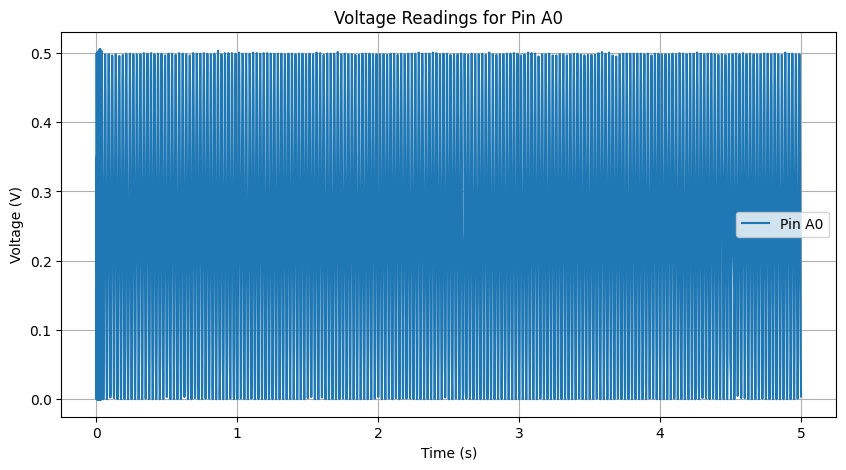

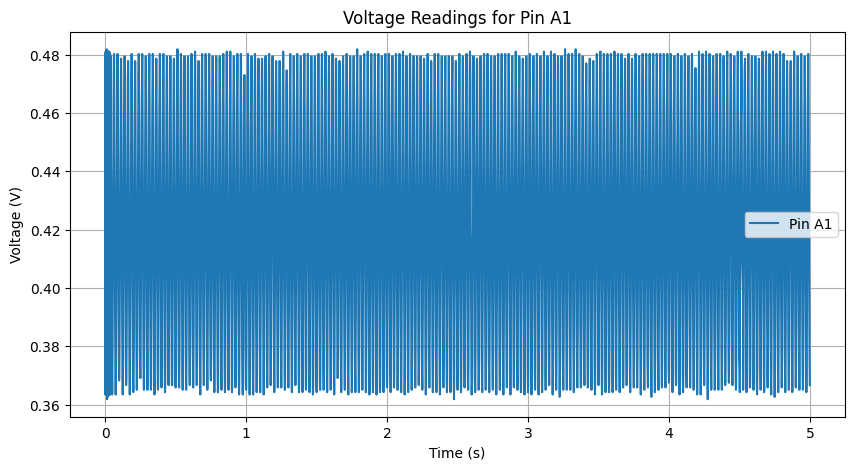

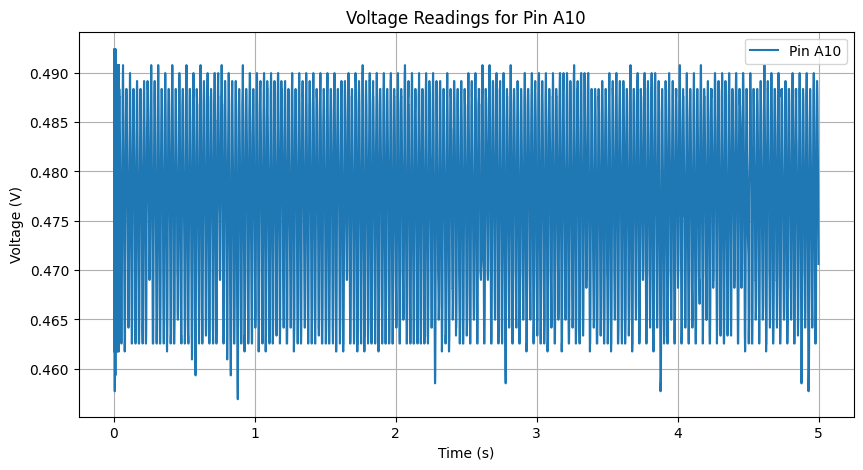

In [31]:
if __name__ == "__main__":
    # Specify which analog pins you want to read from (e.g., A0, A1, A2, A3)
    analog_pins_to_read = [0,1,10] # Replace with your actual pins

    # Call the function, specifying the port and other parameters
    control_teensy(port='/dev/tty.usbmodem155143201', baud_rate=115200, sample_rate=1000, running_time=5, analog_pins=analog_pins_to_read)